Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/bgpelkie/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

In [3]:
## Load existing data

In [4]:
with open('constants_2024_12_18.json', 'rt') as f:
    synth_constants = json.load(f) 

In [5]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [6]:
synth_data = pd.read_csv('synth_table_12_18_24_rmse.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [7]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,campaign,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,rmse_distance,experiment_status,rank
0,4bec4e18-80bb-44d9-8508-cc464f14b287,50.221052,124.240610,164.940826,1360.597512,0.362682,7.951422,0.009674,2024_10_04_RandomBaseline_v2,NaN,1700.0,0.029542,0.073083,0.097024,0.800351,1.293424,0.263329,complete,14.0
1,a180d359-a229-4b3e-a615-2991fd549f42,166.906371,105.547296,82.831240,1344.715094,0.109129,26.426030,0.032207,2024_10_04_RandomBaseline_v2,NaN,1700.0,0.098180,0.062087,0.048724,0.791009,1.344181,0.261322,complete,24.0
2,3584700a-8b01-4e59-a53a-1300fd3fac0a,83.477895,57.716266,175.101719,1383.704120,0.218193,13.216927,0.016085,2024_10_04_RandomBaseline_v2,NaN,1700.0,0.049105,0.033951,0.103001,0.813944,1.416920,0.258173,complete,30.0
3,0e6edb88-77c3-4984-a38d-198341bba9e1,190.436887,103.859345,139.812858,1265.890910,0.095645,30.151581,0.036353,2024_10_04_RandomBaseline_v2,NaN,1700.0,0.112022,0.061094,0.082243,0.744642,1.419393,0.271926,complete,32.0
4,68831f53-4a51-4f12-b385-10c50c8fab46,75.225504,170.914159,187.560764,1266.299573,0.242129,11.910339,0.014352,2024_10_04_RandomBaseline_v2,NaN,1700.0,0.044250,0.100538,0.110330,0.744882,1.513687,0.267274,complete,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,05f30d93-c050-49af-b168-c36d1c6abe41,48.755823,68.705266,164.986995,1417.551916,0.778295,7.719435,0.009435,2024_12_18_Optimize_rmse,E8,1700.0,0.028680,0.040415,0.097051,0.833854,1.537251,0.261544,complete,74.0
119,11209250-6f31-4bc3-b60f-852994580d67,17.000000,82.054374,8.500000,1592.445627,2.232143,2.691584,0.003377,2024_12_18_Optimize_rmse,F1,1700.0,0.010000,0.048267,0.005000,0.936733,1.164133,0.135514,complete,6.0
120,8f76373d-4001-45d2-9608-0220318c738f,255.000010,30.157373,255.000010,1159.842607,0.148810,40.373762,0.047823,2024_12_18_Optimize_rmse,F2,1700.0,0.150000,0.017740,0.150000,0.682260,1.607128,0.264174,complete,97.0
121,9a1469d6-a041-402a-80f8-c2c647d10e9b,112.599814,42.670811,81.657276,1463.072099,0.337003,17.827756,0.021965,2024_12_18_Optimize_rmse,F3,1700.0,0.066235,0.025100,0.048034,0.860631,1.479869,0.287399,complete,49.0


In [8]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['rmse_distance']

In [9]:
y_data.min()

-1.689389121597695

## data pre-processing

In [10]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [11]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [12]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [13]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [14]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [15]:
## Concentrations

In [16]:
x_data_norm[:,0]

tensor([ 1.3958e-01,  6.2986e-01,  2.7932e-01,  7.2873e-01,  2.4464e-01,
         1.3248e-02,  6.8823e-01,  9.6792e-01,  3.4684e-01,  5.2266e-01,
         9.2341e-01,  8.2274e-01,  2.6090e-01,  8.1457e-01,  3.5195e-01,
         7.7564e-01,  8.9929e-01,  3.2066e-01,  6.5880e-01,  8.7405e-01,
         4.6219e-01,  2.6754e-02,  9.0631e-02,  3.8195e-01,  5.3007e-01,
         5.4361e-01,  7.9045e-01,  2.1924e-01,  9.7736e-03,  2.7761e-01,
         3.1017e-01,  8.9481e-01,  2.6543e-01,  9.3022e-01,  3.5177e-01,
         1.9465e-01,  2.6124e-01,  8.2756e-01,  5.0021e-01,  8.0085e-01,
         6.5810e-02,  6.2584e-02,  2.5726e-01,  3.2338e-01,  7.4829e-02,
         8.6348e-01,  7.0816e-01,  5.5900e-01,  7.0063e-01,  2.1551e-01,
         5.6752e-01,  6.1768e-01,  5.1171e-01,  2.6443e-01,  9.3069e-01,
         1.9390e-01,  6.9957e-01,  9.1197e-01,  6.0907e-01,  2.8987e-01,
         5.8255e-01,  2.3311e-02,  4.7214e-01,  6.3631e-01,  4.4543e-01,
         6.0223e-01,  7.2870e-01,  1.2600e-01,  5.6

In [17]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [18]:
best_10_ind

tensor([119,  16,   6,  89,  30, 104, 116,  36,  83,  17])

In [19]:
X_best10 = x_data_norm[best_10_ind,:]

In [20]:
X_best10.shape

torch.Size([10, 3])

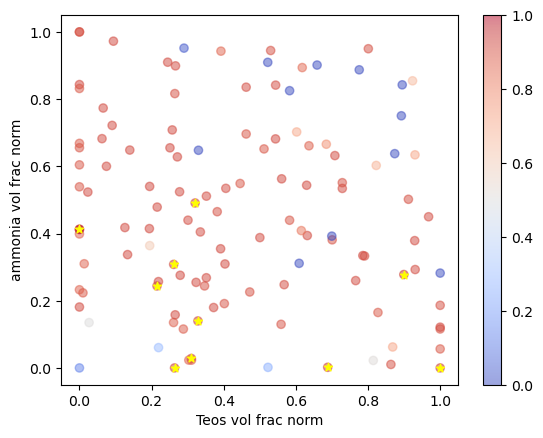

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

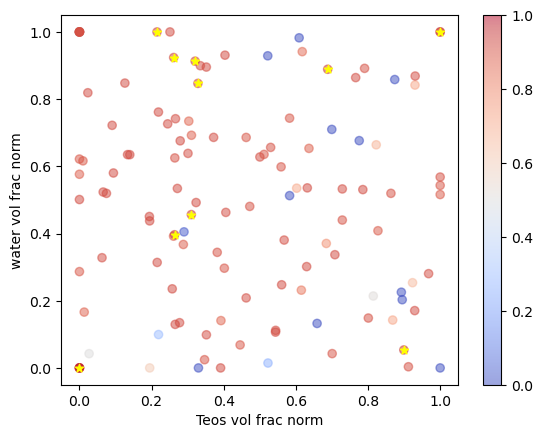

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [23]:
### TSNE rep

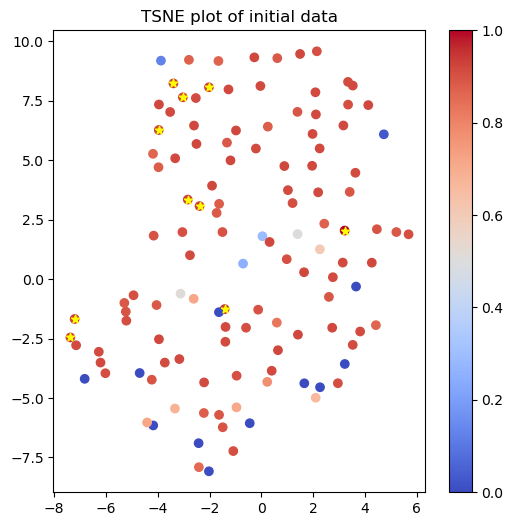

In [24]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [25]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 10  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [26]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [27]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [28]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

print('starting model fit')
start_time = time.time()
fit_gpytorch_mll(mll_nei)
print(f'finished model fit in {time.time() - start_time} s')





starting model fit
finished model fit in 10.528846502304077 s


In [29]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

Text(0.5, 1.0, 'RMSE distance')

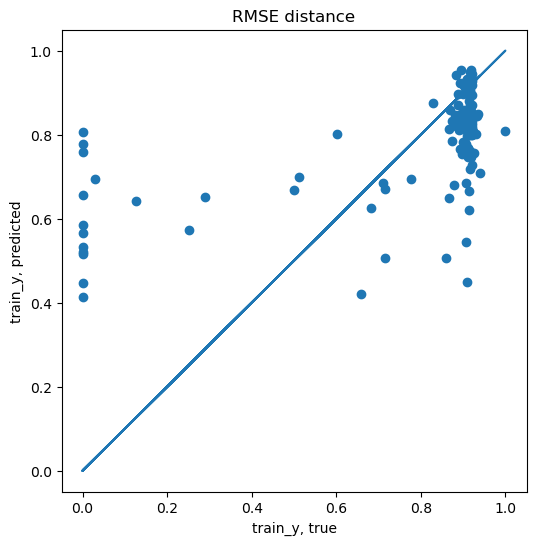

In [30]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)
ax.set_xlabel('train_y, true')
ax.set_ylabel('train_y, predicted')
ax.set_title('RMSE distance')

(array([12.,  1.,  2.,  0.,  0.,  2.,  3.,  4., 25., 74.]),
 array([-7.71373645e-09,  9.99999948e-02,  1.99999997e-01,  3.00000000e-01,
         4.00000002e-01,  5.00000005e-01,  6.00000007e-01,  7.00000010e-01,
         8.00000012e-01,  9.00000015e-01,  1.00000002e+00]),
 <BarContainer object of 10 artists>)

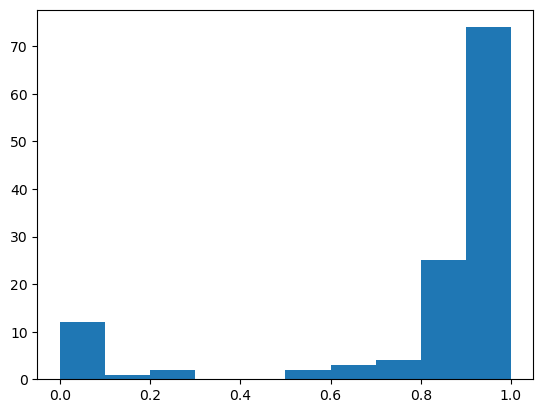

In [31]:
plt.hist(train_y)

In [32]:
train_x.max()

tensor(1.0000, dtype=torch.float64)

In [33]:
# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)
print('starting acq opt')
acq_start = time.time()
# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)
print(f'finished acq opt. in {time.time() - acq_start} s')

starting acq opt
finished acq opt. in 4942.444854021072 s


## Visualize model predictions

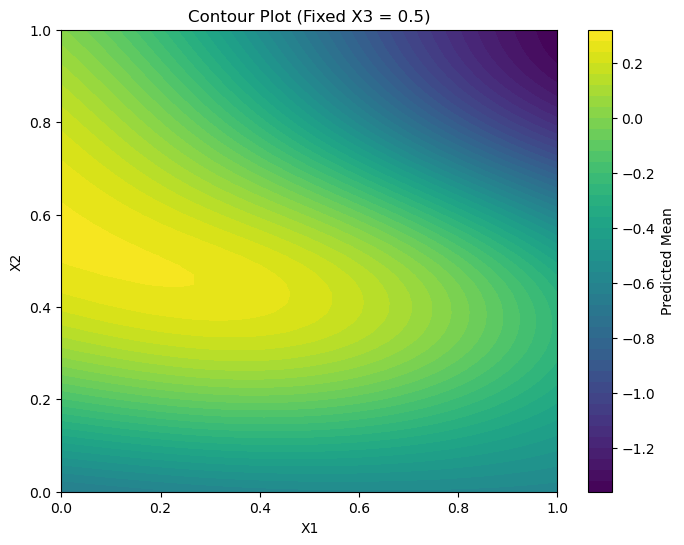

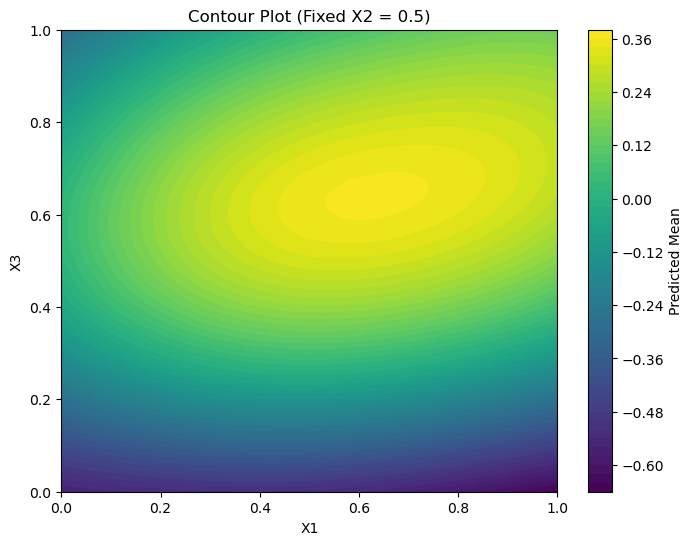

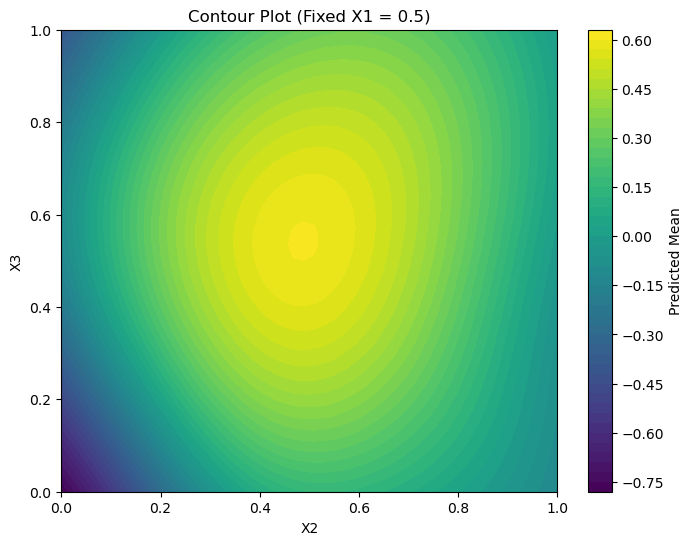

In [34]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.1, 0.1, 0.1]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


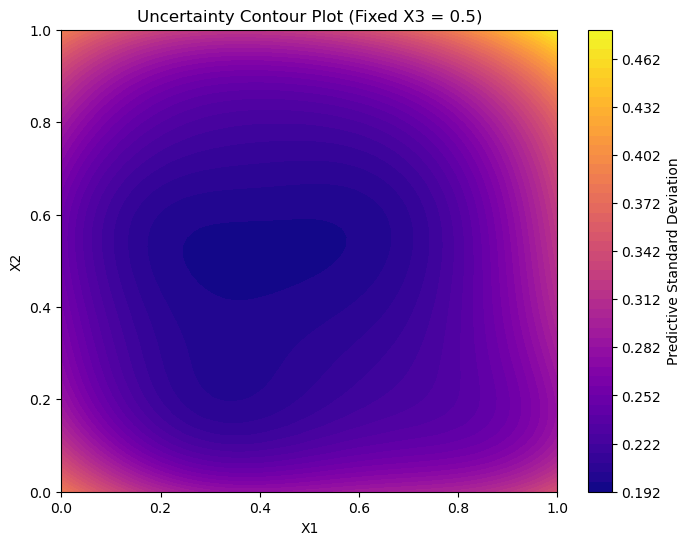

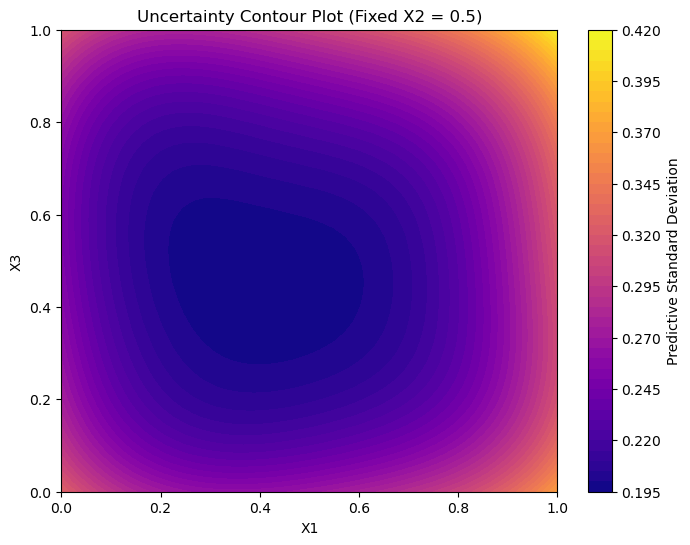

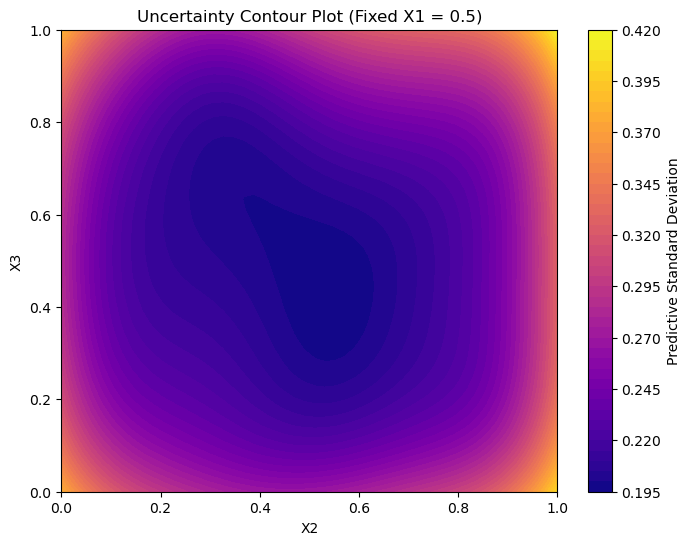

In [35]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

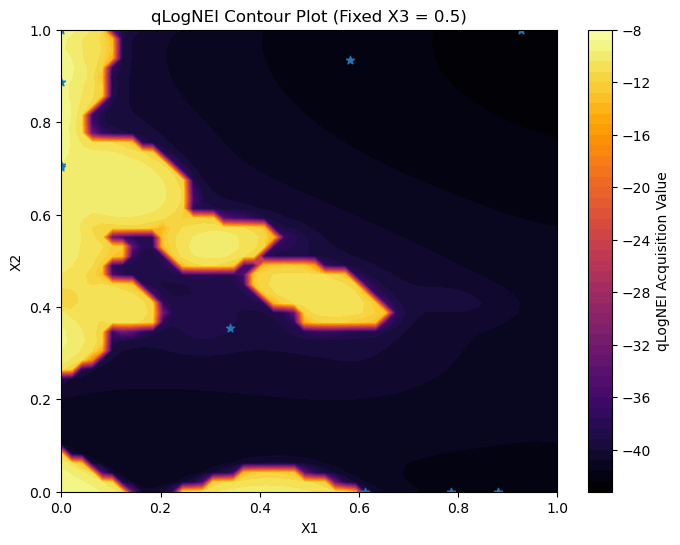

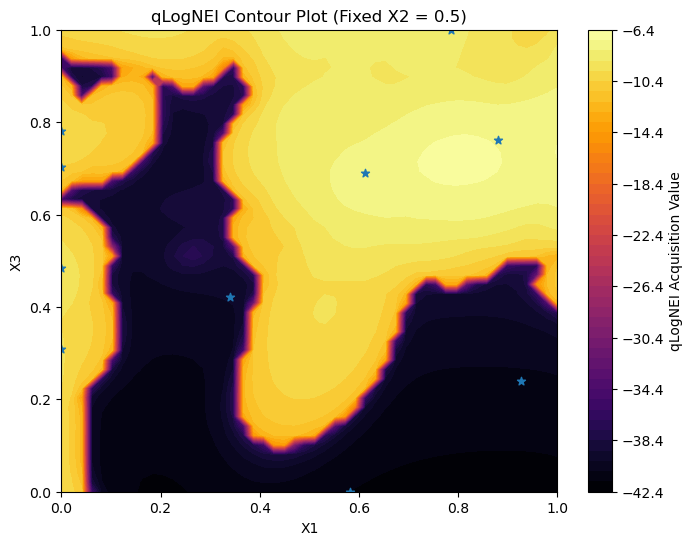

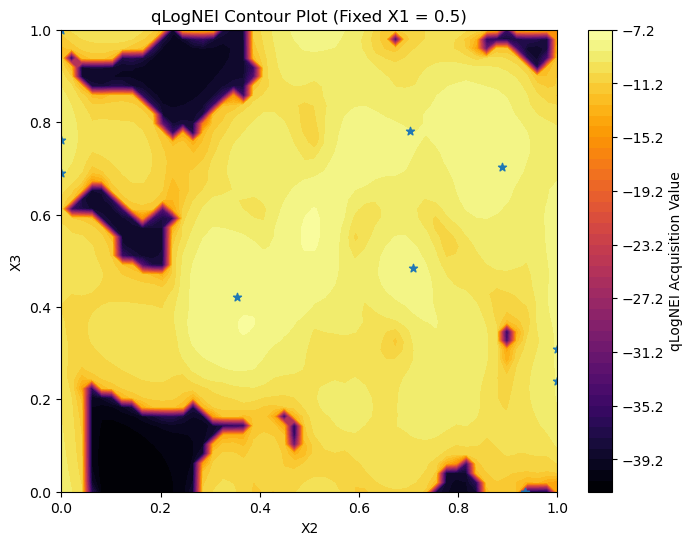

In [36]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.06, 0.06, 0.06]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


## Visualize new batch

In [37]:
tsne = TSNE()

In [38]:
x_data_norm.shape

torch.Size([123, 3])

In [39]:
all_x = torch.cat([x_data_norm, candidates])

In [40]:
x_tsne_og = tsne.fit_transform(all_x)

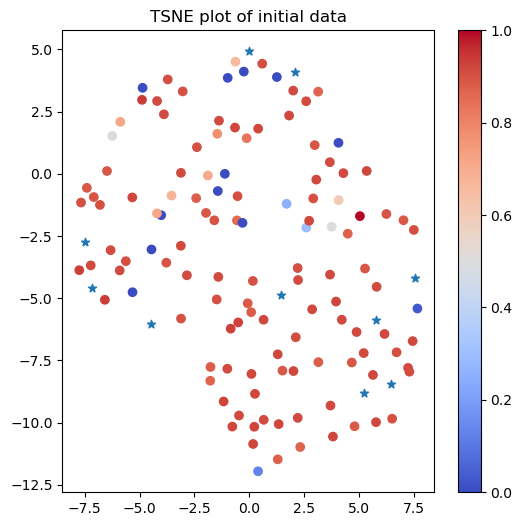

In [41]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [42]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [43]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_2024_12_18.json'
samples_write_fp = 'Sample_table_2025_01_09_CompareOpt_80nmTarget_Round3_rmsedist.csv'


In [44]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [45]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [46]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [47]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [48]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [50]:
synth_table['well'] = wells[len(synth_table):2*len(synth_table)]


In [51]:
synth_table['dilute_well'] = wells[3*len(synth_table):4*len(synth_table)]

## Visualize new batch

In [52]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [53]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [54]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

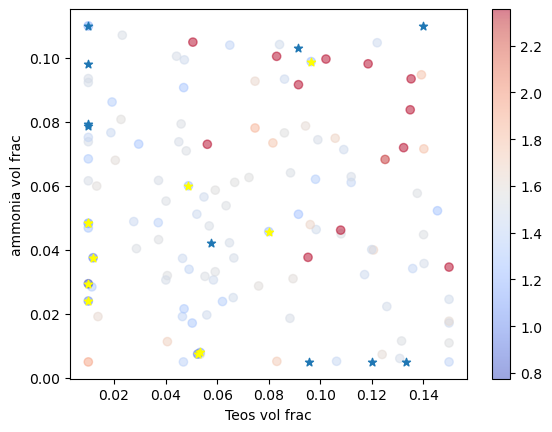

In [55]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/1700, synth_table['ammonia_volume']/target_volume, marker = '*')

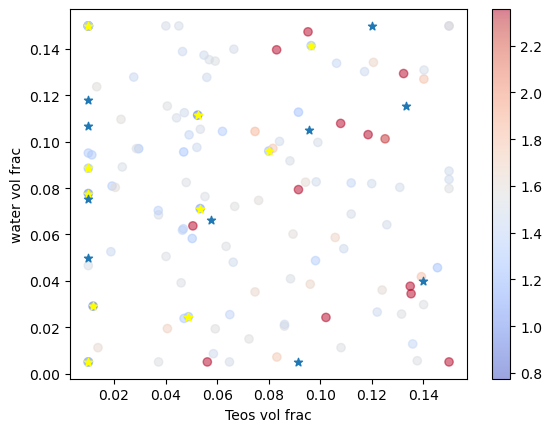

In [56]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha = 0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/1700, synth_table['water_volume']/target_volume, marker = '*')

In [57]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,d25a22b3-7b31-4a34-a6c0-92e45b8ac925,17.000000,166.917798,181.570192,1334.512011,2.232143,2.691584,0.003267,0.0,1700.0,B4,E1
1,57821091-6396-45f7-a85b-d24a45526848,203.983770,8.500000,255.000010,1232.516220,0.186027,32.296438,0.038517,1384.0,316.0,B5,E3
2,853403e1-f5af-4354-ad1d-cb807eab1ccb,155.586515,175.441007,8.500000,1360.472479,0.243893,24.633775,0.030227,1285.0,415.0,B6,E4
3,50c1cea9-a08d-4bc6-b5d4-303a9e32d41b,17.000000,133.996491,200.914244,1348.089265,2.232143,2.691584,0.003266,0.0,1700.0,B8,E5
4,1e274033-bf13-44fd-8b73-443755e82430,226.660523,8.500000,196.201649,1268.637829,0.167415,35.886814,0.043072,1415.0,285.0,C1,E6
5,8b8f760d-9a31-422e-b8c3-da08e19161c6,97.664677,71.870534,112.523159,1417.941629,0.388538,15.463099,0.018948,1039.0,661.0,C2,E8
6,fd3adf41-2f06-47b7-9e04-e87b0ea1a731,162.695743,8.500000,178.565402,1350.238855,0.233236,25.759368,0.031201,1303.0,397.0,C3,F1
7,a383ef01-ff05-4691-8bf7-01e397948833,237.664302,186.999999,67.675927,1207.659773,0.159664,37.629025,0.045339,1429.0,271.0,C4,F2
8,295922f0-fd79-48b4-82ba-fbd227b98e2f,17.000000,134.864871,128.088391,1420.046738,2.232143,2.691584,0.003301,0.0,1700.0,C5,F3
9,9a0ea011-8f4a-4c93-89f9-5ef20af6cb7e,17.000000,186.999999,84.827326,1411.172676,2.232143,2.691584,0.003309,0.0,1700.0,C6,F4


In [58]:
synth_table.to_csv(samples_write_fp)